In [1]:
%pylab inline
#import matplotlib as mpl
#mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import emcee

In [3]:
f = np.loadtxt('../Hugs_photometry/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc2808_multi_v1_catalog-meth1.txt',
              dtype=object)

343134 22511 201413


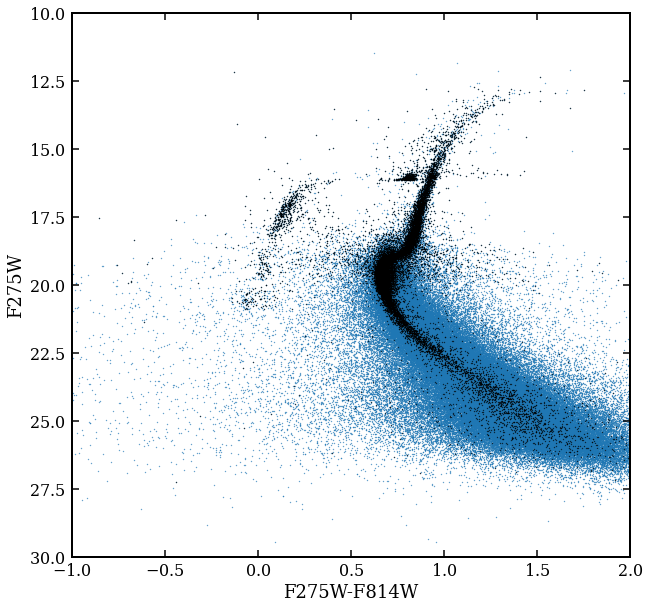

In [11]:
F275 = np.array(f[:,2],dtype=float)
F336 = np.array(f[:,8],dtype=float)
F438 = np.array(f[:,14],dtype=float)
F606 = np.array(f[:,20],dtype=float)
F814 = np.array(f[:,26],dtype=float)

F275_RMS = np.array(f[:,3],dtype=float)
F336_RMS = np.array(f[:,9],dtype=float)
F438_RMS = np.array(f[:,15],dtype=float)
F606_RMS = np.array(f[:,21],dtype=float)
F814_RMS = np.array(f[:,27],dtype=float)

membership_prob = np.array(f[:,32],dtype=float) 

#now I need to mask out the weird values (photometry set to -99.99999) and stars with
#large errors F275W > 0.03, F336W > 0.03, F438W > 0.02
obs_mask = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)&(F275_RMS<0.03)&(F336_RMS<0.03)&(F438_RMS<0.02)
obs_mask_no_err = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)

print(len(F275),np.sum(obs_mask),np.sum(obs_mask_no_err))

F275_orig = F275.copy()
F336_orig = F336.copy()
F438_orig = F438.copy()
F606_orig = F606.copy()
F814_orig = F814.copy()

F275 = F275[obs_mask]
F336 = F336[obs_mask]
F438 = F438[obs_mask]
F606 = F606[obs_mask]
F814 = F814[obs_mask]

fig1 = figure(1,(10,10))

#for age_select in np.unique(mist_age)[::10]:
#    mask_age = (mist_age==age_select)
#
#    plt.plot(mist_f275w[mask_age]-mist_f814w[mask_age],mist_f275w[mask_age]+18.)

plt.scatter(F606_orig-F814_orig,F606_orig,color='C0',s=0.1)
plt.scatter(F606-F814,F606,color='k',s=0.1)
#plt.plot(mist_f275w[mask_age]-mist_f814w[mask_age],mist_f275w[mask_age],color='k')
plt.xlim([-1.,2.])
plt.ylim([30,10])
plt.xlabel('F275W-F814W')
plt.ylabel('F275W')
plt.show()

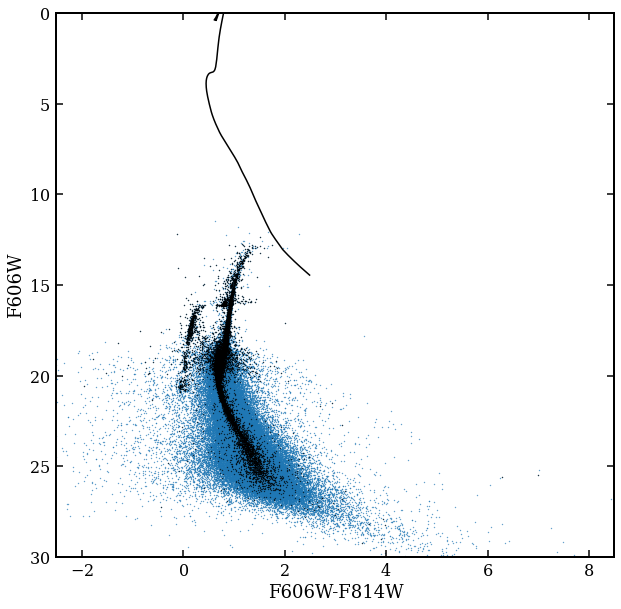

In [16]:
f_basti = np.loadtxt('../Basti_isochrones/FEHm105/10000z0027800y275P04O1D1E1.isc_wfc3')

basti_f275w = f_basti[:,6]
basti_f336w = f_basti[:,7]
basti_f438w = f_basti[:,9]
basti_f814w = f_basti[:,15]
basti_f606w = f_basti[:,12]

fig1 = figure(1,(10,10))

plt.plot(basti_f606w-basti_f814w, basti_f606w,color='k')

plt.scatter(F606_orig-F814_orig,F606_orig,color='C0',s=0.1)
plt.scatter(F606-F814,F606,color='k',s=0.1)
plt.xlim([-2.5,8.5])
plt.ylim([30,0])
plt.xlabel('F606W-F814W')
plt.ylabel('F606W')
plt.show()

In [20]:
#Now I need to add in my priors on the distance modulus and the reddening
#In the paper they addopt uniform priors for all parameters as follows:
#
# age - 10 t0 15 Gyrs
# metallicity - 0.00 to -2.00 dex
# reddening - 0.0 to 1.0 mag
# distance modulus - 12.0 to 16.0 mag
#
#I think what I've written below is the full likelihood function with a uniform prior
#for distance and reddening. The basic way this works is
#
# 1) define prior such that it's 1.0 if you are within the range and -inf if not
# 2) If you are outside the zone your liklihood automatically drops to -inf
# 3) Write the likelihood with the parameters contained in it
# 4) Return the log prior plus the log likelihood, this is the fucntion that emcee takes in
#    and gives the true answers.

def log_prior(theta):
    dist_mod, reddening = theta
    if 0.0 < reddening < 1.0 and 12.0 < dist_mod < 16.0:
        return 0.0
    return -np.inf

#In this case x and y would be the star color (x)  and star (y)

def log_probability(theta, x, y):
    dist_mod, reddening = theta #emcee assumes your prior parameters are in theta
    lp = log_prior(theta)
    
    #Now load in a given isochrone:
    f_basti = np.loadtxt('../Basti_isochrones/FEHm105/10000z0027800y275P04O1D1E1.isc_wfc3')

    basti_f275w = f_basti[:,6]
    basti_f336w = f_basti[:,7]
    basti_f438w = f_basti[:,9]
    basti_f606w = f_basti[:,12]
    basti_f814w = f_basti[:,15]

    basti_color = (basti_f606w-basti_f814w)+reddening #Here is where our reddening comes into play
    basti_mag = basti_f606w+dist_mod #Here is where the distance modulus comes into play

    obs_cmd_color = x
    obs_cmd_mag = y
    
    chi_color_list, chi_mag_list = [],[]

    for ii in range(len(F606)-1):

        obs_cmd_mag = F606[ii]
        obs_cmd_color = F606[ii]-F814[ii]

        #obs_cmd_mag_err = F606_RMS[ii]
        #obs_cmd_color_err = np.sqrt(F606_RMS[ii]**2.0+F814_RMS[ii]**2.0)

        cmd_dist = np.sqrt((basti_color-(obs_cmd_color))**2.0+(basti_mag-obs_cmd_mag)**2.0) #distance between observed point and isochrone points
        cmd_arg = np.argmin(cmd_dist) #find the point on the 
        chi_mag = (obs_cmd_mag - basti_mag[cmd_arg])
        chi_color = (obs_cmd_color - basti_color[cmd_arg])

        chi_color_list.append(chi_color)
        chi_mag_list.append(chi_mag)

    assert shape(chi_mag_list)==shape(np.array(chi_mag_list)**2.0)

    #Now I need to add in a prior
    Likelihood = -np.sum(np.array(chi_mag_list)**2+np.array(chi_color_list)**2)

    if not np.isfinite(lp):
        return -np.inf
    return lp + Likelihood

In [21]:
#I should just be able to slot this function into emcee and let it rip?
obs_cmd_color, obs_cmd_mag = F606-F814,F606

pos = np.array([15.,0.5]) + 1.0e-3*np.random.randn(5, 2) #I think this is an initial guess to give the MCMC
nwalkers, ndim = 5, 2 #I think ndim is the number of free parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(obs_cmd_color, obs_cmd_mag))

sampler.run_mcmc(pos, 500, progress=True)

100%|██████████| 500/500 [25:18<00:00,  3.04s/it]


State([[15.60496304  0.16330618]
 [15.64533956  0.18000043]
 [15.61894263  0.18078899]
 [15.64512059  0.18074467]
 [15.61278691  0.17629115]], log_prob=[-741.85375439 -738.46882934 -738.71004441 -738.64777789 -738.29713724], blobs=None, random_state=('MT19937', array([ 240976832, 3139476443, 2971701467, 2151952817, 1626344467,
        897153889, 4219404484,  895007011, 3677357995, 4006230876,
        574256044, 1912921737, 3517094466, 3556029243,  936020841,
       4058277512,  198043569,  555931789, 2696349373, 4040922457,
        655290632,  246704319, 3133164499, 1396221213, 4282496107,
       2580970763, 3956052639, 2903911514, 1497676168,  574388986,
        982802531, 2495189184, 2827438418, 4217754598, 3698359644,
       3380227564, 4247512761, 2807938813, 2845940646,  667415896,
       3514576845, 2075934551, 1586643867, 1045149682, 3684000652,
       3540519708, 1266497730,  271877920,   14051871,  946373559,
       1007579839,  398349938, 1016253548, 3872387458,  939313488,
 

2


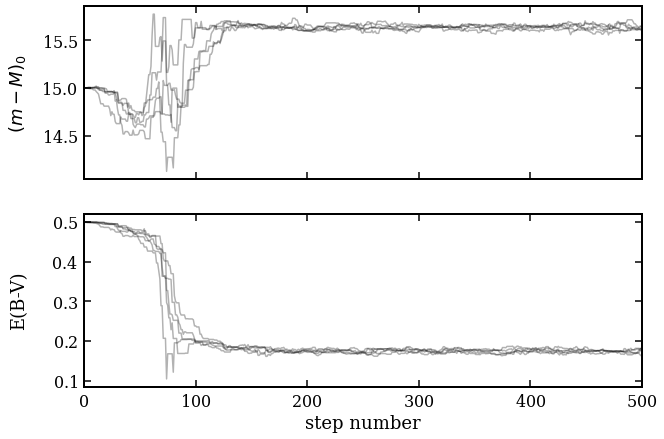

In [22]:
print(ndim)

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$(m-M)_{0}$", "E(B-V)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(2500, 2)


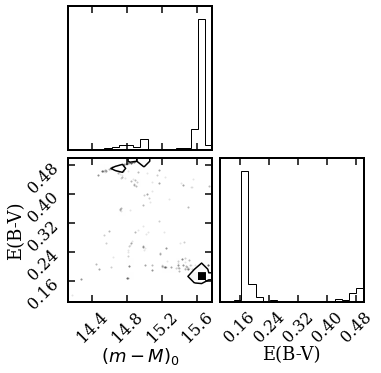

In [23]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [24]:
samples[-1]

best_fit_modulus = np.median(samples[-1][:,0])
best_fit_reddening = np.median(samples[-1][:,1])

print(best_fit_modulus,best_fit_reddening)

15.618942632471155 0.18000042597818075


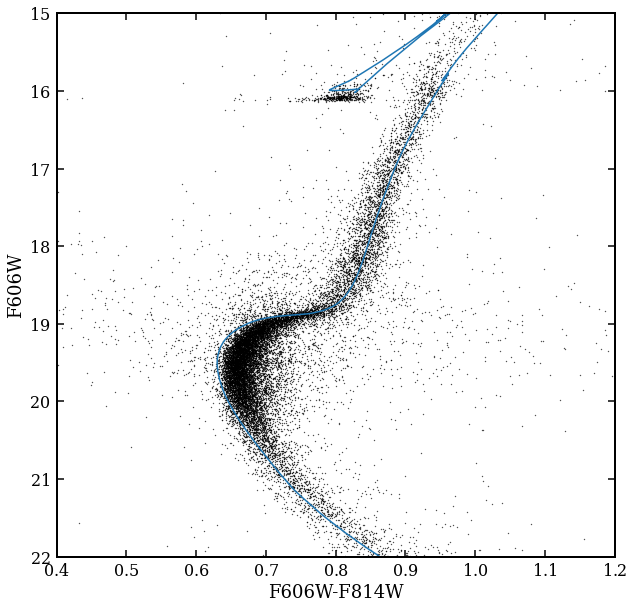

In [28]:
fig1 = figure(1,(10,10))
basti_color, basti_mag = basti_f606w-basti_f814w+best_fit_reddening, basti_f606w+best_fit_modulus
plt.plot(basti_color,basti_mag,color='C0')
#plt.scatter(basti_color_min,basti_mag_min,color='C1',s=0.1)

plt.scatter(F606-F814,F606,color='k',s=0.1)
#plt.plot(mist_f275w[mask_age]-mist_f814w[mask_age],mist_f275w[mask_age],color='k')
plt.xlim([0.4,1.2])
plt.ylim([22,15])

#plt.xlim([-0.5,2.0])
#plt.ylim([25.0,12.5])

#plt.text(-0.25,14.0,'Age: '+str(age_final)+' Gyr',fontsize=20)
#plt.text(-0.25,15.0,'Z: '+str(Z_final),fontsize=20)

plt.xlabel('F606W-F814W')
plt.ylabel('F606W')
plt.show()

In [29]:
#So from here I need to figure out how to scale this to work with many isochrones
#I think I know how, but it's a little janky.
#
# 1) for every isochrone calculate it's best fit dist mod and redenning
# 2) use that best fit to calculate the likelihood
# 3) select the maximum likelihood for that model

def log_prior(theta):
    dist_mod, reddening = theta
    if 0.0 < reddening < 1.0 and 12.0 < dist_mod < 16.0:
        return 0.0
    return -np.inf

#In this case x and y would be the star color (x)  and star (y)

def log_probability(theta, x, y, isochrone_file = None):
    #This version of the function will take in a arbitrary file and 
    #use that, hopefully putting it in as an option doesn't interfere with emcee
    #
    #Okay that seems to work 
    
    import sys
    import numpy as np
    
    dist_mod, reddening = theta #emcee assumes your prior parameters are in theta
    lp = log_prior(theta)
    
    #Now load in a given isochrone:
    if isochrone_file == None:
        print('please define an isochrone to use')
        sys.exit()
    else:
        f_basti = np.loadtxt(isochrone_file)
        basti_f275w = f_basti[:,6]
        basti_f336w = f_basti[:,7]
        basti_f438w = f_basti[:,9]
        basti_f606w = f_basti[:,12]
        basti_f814w = f_basti[:,15]

    basti_color = (basti_f606w-basti_f814w)+reddening #Here is where our reddening comes into play
    basti_mag = basti_f606w+dist_mod #Here is where the distance modulus comes into play

    obs_cmd_color = x
    obs_cmd_mag = y
    
    chi_color_list, chi_mag_list = [],[]

    for ii in range(len(F606)-1):

        obs_cmd_mag = F606[ii]
        obs_cmd_color = F606[ii]-F814[ii]

        #obs_cmd_mag_err = F606_RMS[ii]
        #obs_cmd_color_err = np.sqrt(F606_RMS[ii]**2.0+F814_RMS[ii]**2.0)

        cmd_dist = np.sqrt((basti_color-(obs_cmd_color))**2.0+(basti_mag-obs_cmd_mag)**2.0) #distance between observed point and isochrone points
        cmd_arg = np.argmin(cmd_dist) #find the point on the 
        chi_mag = (obs_cmd_mag - basti_mag[cmd_arg])
        chi_color = (obs_cmd_color - basti_color[cmd_arg])

        chi_color_list.append(chi_color)
        chi_mag_list.append(chi_mag)

    assert shape(chi_mag_list)==shape(np.array(chi_mag_list)**2.0)

    #Now I need to add in a prior
    Likelihood = -np.sum(np.array(chi_mag_list)**2+np.array(chi_color_list)**2)

    if not np.isfinite(lp):
        return -np.inf
    return lp + Likelihood

In [30]:
#I should just be able to slot this function into emcee and let it rip?
obs_cmd_color, obs_cmd_mag = F606-F814,F606

pos = np.array([15.,0.5]) + 1.0e-3*np.random.randn(5, 2) #I think this is an initial guess to give the MCMC
nwalkers, ndim = 5, 2 #I think ndim is the number of free parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(obs_cmd_color, obs_cmd_mag,'../Basti_isochrones/FEHm105/10000z0027800y275P04O1D1E1.isc_wfc3'))

sampler.run_mcmc(pos, 500, progress=True)

100%|██████████| 500/500 [25:19<00:00,  3.04s/it]


State([[15.58963854  0.18236737]
 [15.67608853  0.1718961 ]
 [15.65998471  0.16895557]
 [15.65285924  0.16761876]
 [15.60780698  0.17543681]], log_prob=[-740.28730525 -738.94295654 -738.72549915 -738.91148801 -738.4723709 ], blobs=None, random_state=('MT19937', array([ 240976832, 3139476443, 2971701467, 2151952817, 1626344467,
        897153889, 4219404484,  895007011, 3677357995, 4006230876,
        574256044, 1912921737, 3517094466, 3556029243,  936020841,
       4058277512,  198043569,  555931789, 2696349373, 4040922457,
        655290632,  246704319, 3133164499, 1396221213, 4282496107,
       2580970763, 3956052639, 2903911514, 1497676168,  574388986,
        982802531, 2495189184, 2827438418, 4217754598, 3698359644,
       3380227564, 4247512761, 2807938813, 2845940646,  667415896,
       3514576845, 2075934551, 1586643867, 1045149682, 3684000652,
       3540519708, 1266497730,  271877920,   14051871,  946373559,
       1007579839,  398349938, 1016253548, 3872387458,  939313488,
 

2


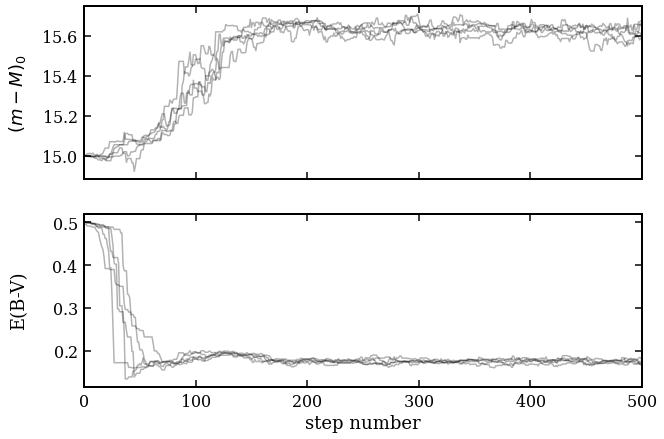

In [31]:
print(ndim)

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$(m-M)_{0}$", "E(B-V)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(2500, 2)


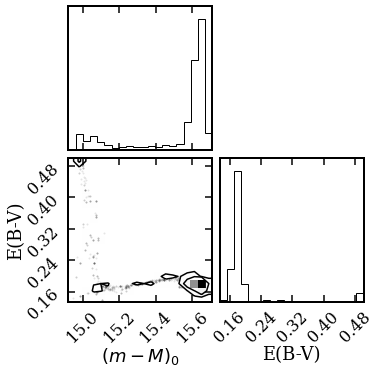

In [32]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [34]:
samples[-1]

best_fit_modulus = np.median(samples[-1][:,0])
best_fit_reddening = np.median(samples[-1][:,1])

print(best_fit_modulus,best_fit_reddening)

15.652859244176943 0.17189609923931456


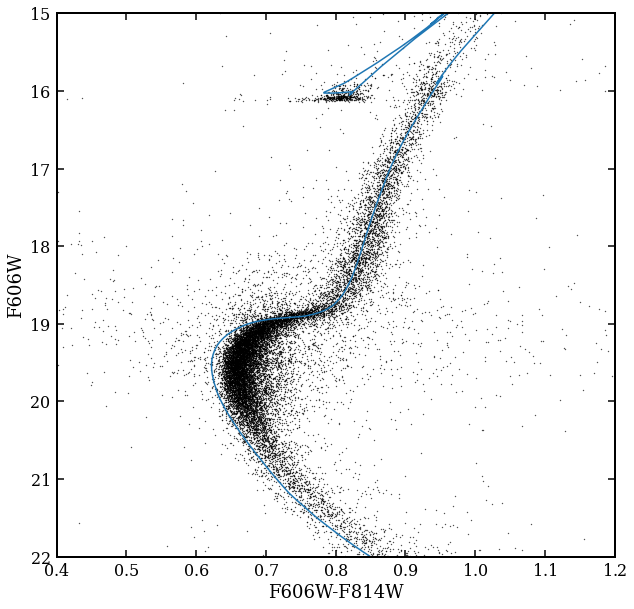

In [35]:
fig1 = figure(1,(10,10))
basti_color, basti_mag = basti_f606w-basti_f814w+best_fit_reddening, basti_f606w+best_fit_modulus
plt.plot(basti_color,basti_mag,color='C0')
#plt.scatter(basti_color_min,basti_mag_min,color='C1',s=0.1)

plt.scatter(F606-F814,F606,color='k',s=0.1)
#plt.plot(mist_f275w[mask_age]-mist_f814w[mask_age],mist_f275w[mask_age],color='k')
plt.xlim([0.4,1.2])
plt.ylim([22,15])

#plt.xlim([-0.5,2.0])
#plt.ylim([25.0,12.5])

#plt.text(-0.25,14.0,'Age: '+str(age_final)+' Gyr',fontsize=20)
#plt.text(-0.25,15.0,'Z: '+str(Z_final),fontsize=20)

plt.xlabel('F606W-F814W')
plt.ylabel('F606W')
plt.show()